In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys

In [4]:
path = os.path.join(os.getcwd(),"drive/My Drive/NEU/CS 7150/HW 3/ResNet Vs CNN Denoising")
sys.path.append(path)

In [5]:
from models import ResNet32, CNN32

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import numpy as np
from typing import Union
from torch.utils.data import DataLoader, Dataset
from pickle import dump, load
from torchsummary import summary

In [7]:
trfms= transforms.Compose([transforms.ToTensor()])

In [8]:
trainset = torchvision.datasets.CIFAR10(
    root = "./data", train = True, download= True, transform=trfms)
testset = torchvision.datasets.CIFAR10(
    root= './data', train = False, download= True, transform=trfms)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def add_normal_noise(
    input: torch.Tensor,
    std: float=.1):
  """Add Gaussian noise to input."""
  return torch.clamp(
      input + torch.normal(
          mean=0.,
          std=std, 
          size=input.shape),
          min=0.0, 
          max=1.0)

In [10]:
class CustomDataset(Dataset):
  """Prepare dataset with noisy and actual image"""
  def __init__(self, dataset, transform=None):
      self.data = dataset.data
      self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = self.data[idx]
    if self.transform:
        img = self.transform(img)
        
    return (add_normal_noise(img), img) 

In [11]:
trainloader = DataLoader(
    dataset = CustomDataset(trainset, transform=trfms), batch_size = 1, shuffle = True)
testloader = DataLoader(
    dataset=CustomDataset(testset, transform=trfms), batch_size = 1, shuffle = False)


Preparing train and test set such that same datasets are used across ResNet32 and CNN32

In [12]:
custom_trainset, custom_testset = [], []
for X, Y in tqdm(trainloader):
  custom_trainset.append((X[0], Y[0]))

for X, Y in tqdm(testloader):
  custom_testset.append((X[0], Y[0]))

del trainset, testset

In [13]:
class CustomDataset(Dataset):
  def __init__(self, dataset):
    self.data = dataset
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return(self.data[idx])

In [14]:
BATCH_SIZE = 512

In [15]:
trainloader = DataLoader(
    dataset = CustomDataset(custom_trainset), batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(
    dataset = CustomDataset(custom_testset), batch_size = BATCH_SIZE, shuffle = False)

In [16]:
img, noisy_img = next(iter(trainloader))
img.shape, noisy_img.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512, 3, 32, 32]))

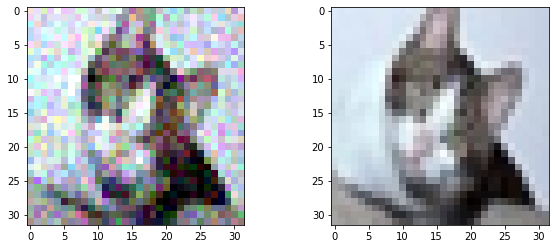

In [17]:
i = np.random.choice(len(img))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
ax1.imshow(img[i].permute(1,2,0))
ax2.imshow(noisy_img[i].permute(1,2,0))
plt.show()

In [18]:
def PSNR(
    img: torch.Tensor,
    noisy_img: torch.Tensor,
    max_pixel: Union[int, float]=1.0) -> torch.tensor:
  """
  Compares Peak Signal-to-Noise Ratio between noisy and actual image/s.
  
  Parameters:
  -----------
  img: tensor of shape (B, C, H, W)

  noisy_img: tensor of shape (B, C, H, W)
  
  max_pixel: float
  """
  assert noisy_img.shape == img.shape
  mse = torch.mean((noisy_img - img)**2, dim=[1,2,3])
  return 10 * torch.log10(max_pixel**2/mse)

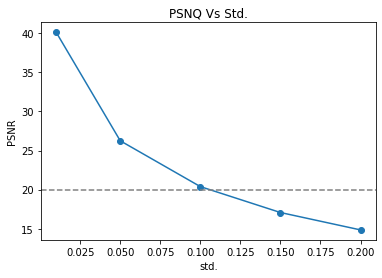

In [19]:
stds = [.01, .05, .1, .15, .2]
avg_psnr = []
for std in stds:
  noisy_img = add_normal_noise(img, std=std)
  avg_psnr.append(torch.mean(PSNR(img, noisy_img)))

plt.plot(stds, avg_psnr)
plt.scatter(stds, avg_psnr)
plt.ylabel("PSNR")
plt.xlabel("std.")
plt.title("PSNQ Vs Std.")
plt.axhline(20, linestyle="dashed", color="grey")
plt.show()

In [20]:
def loss(
    output: torch.Tensor, 
    target: torch.Tensor) -> float:
  output = torch.clamp(output, min=0.0, max=1.0)
  return torch.mean((output-target)**2)

In [21]:
resnet32 = ResNet32()
summary(resnet32.to("cuda"), input_size=img.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
              ReLU-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]           2,112
            Conv2d-9          [-1, 128, 32, 32]          73,856
             ReLU-10          [-1, 128, 32, 32]               0
      BatchNorm2d-11          [-1, 128, 32, 32]             256
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 128,

In [22]:
resnet32

ResNet32(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv2): Conv2d(64, 128

In [23]:
def train(
    model, 
    trainloader, 
    testloader,
    epochs, 
    lr, 
    model_weights_save_path=None):
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  adam = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
  metrics = {"train": {"loss":[]}, "test": {"loss": []}}
  min_test_loss = 1e10

  if model_weights_save_path is None:
    model_weights_save_path = os.getcwd()

  model_name = os.path.basename(model_weights_save_path)
  model_metrics_save_path = os.path.join(
      model_weights_save_path.replace(model_name, ""), model_name + "_metrics.pickle")

  t = tqdm(range(epochs))
  for i in t:

    total_loss = 0.0
    total_size = 0 
    with torch.set_grad_enabled(True):
      model.train()
      for X, Y in tqdm(trainloader, leave=False):  
        X = X.to(device)
        Y = Y.to(device)
        total_size += len(X)
        adam.zero_grad()
        Y_pred = model(X)
        loss_ = loss(Y_pred, Y)
        total_loss += loss_.data * len(X)
        loss_.backward()
        adam.step()
      metrics["train"]["loss"].append(total_loss/ total_size)

    total_loss = 0.0
    total_size = 0 
    with torch.set_grad_enabled(False):
      model.eval()
      for X, Y in tqdm(testloader, leave=False):  
        X = X.to(device)
        Y = Y.to(device)
        total_size += len(X)
        Y_pred = model(X)
        loss_ = loss(Y_pred, Y)
        total_loss += loss_.data * len(X)
      metrics["test"]["loss"].append(total_loss/ total_size)

      # save best performing model for test dataset
      if metrics["test"]["loss"][-1] < min_test_loss:
        min_test_loss = metrics["test"]["loss"][-1]
        torch.save(model.state_dict(), model_weights_save_path)

    t.set_description(f"Epoch: {i+1}, "
                      f"loss: train: {metrics['train']['loss'][-1]:.6f}, "
                      f"test: {metrics['test']['loss'][-1]:.6f}")


  dump(metrics, open(model_metrics_save_path, mode="wb"))
  
  # load weights corresponding to best performing model
  model.load_state_dict(torch.load(model_weights_save_path))
  return model, metrics

In [24]:
EPOCHS = 10
LEARNING_RATE = 1e-3

In [25]:
# resnet32, resnet32_metrics = train(
#     model=resnet32, 
#     trainloader=trainloader, 
#     testloader=testloader, 
#     epochs=EPOCHS, 
#     lr=LEARNING_RATE, 
#     model_weights_save_path=os.path.join(path, "resnet32"))

In [26]:
# load model and its metrics if already trained
model_weights_save_path=os.path.join(path, "resnet32")
resnet32.load_state_dict(torch.load(model_weights_save_path))
resnet32.eval()

model_name = os.path.basename(model_weights_save_path)
model_metrics_save_path = os.path.join(
      model_weights_save_path.replace(model_name, ""), model_name + "_metrics.pickle")
resnet32_metrics = load(open(model_metrics_save_path,"rb"))

In [27]:
test_psnr = np.array([])
with torch.set_grad_enabled(False):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  resnet32.eval()
  for X, Y in tqdm(testloader, leave=True):  
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = resnet32(X)
    test_psnr = np.append(test_psnr, PSNR(Y,Y_pred).cpu().numpy())

np.mean(test_psnr), np.std(test_psnr)

(28.364012303733826, 1.2080353543533489)

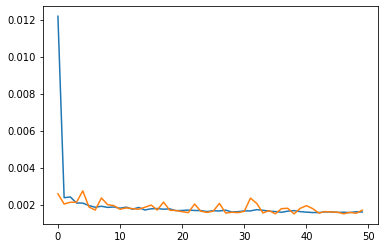

In [28]:
plt.plot(resnet32_metrics['train']['loss'], label="train")
plt.plot(resnet32_metrics['test']['loss'], label="test")
plt.show()

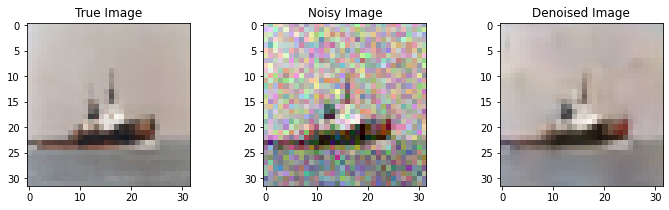

In [29]:
resnet32.eval()
X, Y = next(iter(testloader))
X = X.to(device)
Y_hat = resnet32(X)

i = np.random.choice(len(X))
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(4*3, 3))
ax1.imshow(Y[i].cpu().permute(1,2,0))
ax2.imshow(X[i].cpu().permute(1,2,0))
ax3.imshow(Y_hat[i].cpu().permute(1,2,0).detach().numpy())
ax1.set_title('True Image')
ax2.set_title('Noisy Image')
ax3.set_title('Denoised Image')
plt.show()

In [30]:
with torch.no_grad():
  torch.cuda.empty_cache()

# Without Skip Connections

In [31]:
cnn32 = CNN32()
summary(cnn32.to("cuda"), input_size=img.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
              ReLU-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
              ReLU-9          [-1, 128, 32, 32]               0
      BatchNorm2d-10          [-1, 128, 32, 32]             256
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

In [32]:
cnn32

CNN32(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [33]:
# cnn32, cnn32_metrics = train(
#     model=cnn32, 
#     trainloader=trainloader, 
#     testloader=testloader, 
#     epochs=EPOCHS, 
#     lr=LEARNING_RATE, 
#     model_weights_save_path=os.path.join(path, "cnn32"))

In [34]:
# load model and its metrics if already trained
model_weights_save_path=os.path.join(path, "cnn32")
cnn32.load_state_dict(torch.load(model_weights_save_path))
cnn32.eval()

model_name = os.path.basename(model_weights_save_path)
model_metrics_save_path = os.path.join(
      model_weights_save_path.replace(model_name, ""), model_name + "_metrics.pickle")
cnn32_metrics = load(open(model_metrics_save_path,"rb"))

In [35]:
test_psnr = np.array([])
with torch.set_grad_enabled(False):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  cnn32.eval()
  for X, Y in tqdm(testloader, leave=True):  
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = cnn32(X)
    test_psnr = np.append(test_psnr, PSNR(Y,Y_pred).cpu().numpy())

np.mean(test_psnr), np.std(test_psnr)

(28.41445696659088, 1.29178012958954)

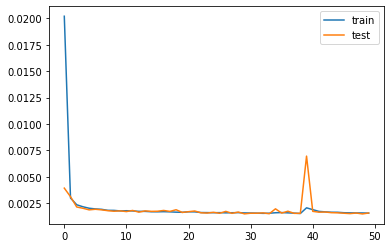

In [36]:
plt.plot(cnn32_metrics['train']['loss'], label="train")
plt.plot(cnn32_metrics['test']['loss'], label="test")
plt.legend()
plt.show()

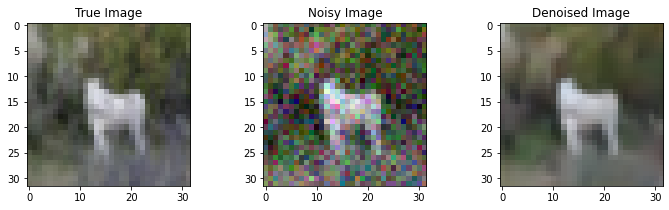

In [37]:
cnn32.eval()
X, Y = next(iter(testloader))
X = X.to(device)
Y_hat = cnn32(X)
i = np.random.choice(len(X))
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(4*3, 3))
ax1.imshow(Y[i].cpu().permute(1,2,0))
ax2.imshow(X[i].cpu().permute(1,2,0))
ax3.imshow(Y_hat[i].cpu().permute(1,2,0).detach().numpy())
ax1.set_title('True Image')
ax2.set_title('Noisy Image')
ax3.set_title('Denoised Image')
plt.show()